In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/ParkDatasets/ParkDatasetAug'
class_names = ['Aedes albopictus', 'Aedes vexans', 'Anopheles sinensis', 'Culex pipiens', 'Culex tritaeniorhynchus', 'Non vectors']

SDO = 0.4

NUM_EPOCH_PER_TRAIN = 40

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.4
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 10

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.80, 0.2, 0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=15, restore_best_weights = True)


2022-09-28 21:48:09.635703: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add


In [3]:
def buildSDModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(SDO)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(SDO)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(SDO)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(SDO)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(SDO)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(6, activation='softmax')(drop_2)
    model = Model(inputs=input0, outputs=output)
    return model

In [4]:
def loadVGG16ImageNetWeightsSD(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[1].set_weights(layer.get_weights()),
        elif layer.name == 'block1_conv2': 
            model.layers[2].set_weights(layer.get_weights()),
        elif layer.name == 'block2_conv1': 
            model.layers[5].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[6].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[9].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[16].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[27].set_weights(layer.get_weights())
    return model


In [5]:
def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

In [6]:
def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                # find index no
                no = selectedFile.rfind('_') 
                # select all files that have the same index no.
                SelectedFiles = '*' + selectedFile[no:] 
                # move all the selected files
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                # find index no
                no = selectedFile.rfind('_') 
                # select all files that have the same index no.
                SelectedFiles = '*' + selectedFile[no:] 
                # move all the selected files
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            SelectedFiles = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )

In [7]:
def read_ds(src_dir):
    
    train_dir = src_dir  + '/train'
    val_dir = src_dir    + '/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    return (train_ds, val_ds)



In [8]:
def preprocessDS(train_ds, val_ds):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))




    # Load the dataset onto GPU RAM for superspeed
    train_ds = train_ds.cache()
    val_ds = val_ds.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds = train_ds.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds   = val_ds.shuffle(val_num_batch, reshuffle_each_iteration=False)


    # prefetch the datasets for lower latency
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    return (train_ds, val_ds)
    #...

In [9]:
def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model


In [10]:
def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    history = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    return history

In [11]:
def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [12]:
def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


In [13]:
def saveSDOModel(model):
    path = './models/Model_SDO_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

In [14]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp9qy9myw8/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp9qy9myw8/train/Aedes vexans/ = 4723.
No. of files in "/tmp/tmp9qy9myw8/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp9qy9myw8/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp9qy9myw8/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp9qy9myw8/val/Aedes vexans/ = 1178.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp9qy9myw8/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp9qy9myw8/train/Anopheles sinensis/ = 4753.
No. of files in "/tmp/tmp9qy9myw8/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp9qy9myw8/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp9qy9myw8/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp9qy9myw8/val/Anopheles sinensis/ = 1170.
Foun

In [15]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)

Found 28679 files belonging to 6 classes.


2022-09-28 21:48:23.026269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 21:48:23.799725: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22223 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 7061 files belonging to 6 classes.


In [16]:
model = buildSDModel()
model.summary()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img0 (InputLayer)           [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 spatial_dropout2d (SpatialD  (None, 112, 112, 64)     0         
 ropout2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856 

In [17]:
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
maxAcc = np.max(fitHistory.history['val_accuracy'])

Start fitting from 2022/09/28-21:48:31

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-28 21:48:37.833617: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-28 21:48:40.115962: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3585/3585 [==============================] - 243s 65ms/step - loss: 1.6733 - accuracy: 0.2769 - val_loss: 1.2836 - val_accuracy: 0.4617 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3585/3585 [==============================] - 226s 63ms/step - loss: 1.0925 - accuracy: 0.5631 - val_loss: 0.8528 - val_accuracy: 0.6496 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3585/3585 [==============================] - 221s 62ms/step - loss: 0.6887 - accuracy: 0.7369 - val_loss: 0.4895 - val_accuracy: 0.8259 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3585/3585 [==============================] - 222s 62ms/step - loss: 0.4279 - accuracy: 0.8431 - val_loss: 0.3542 - val_accuracy: 0.8738 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
3585/3585 [=========

Maximum test accuracy is at 97.13 %.


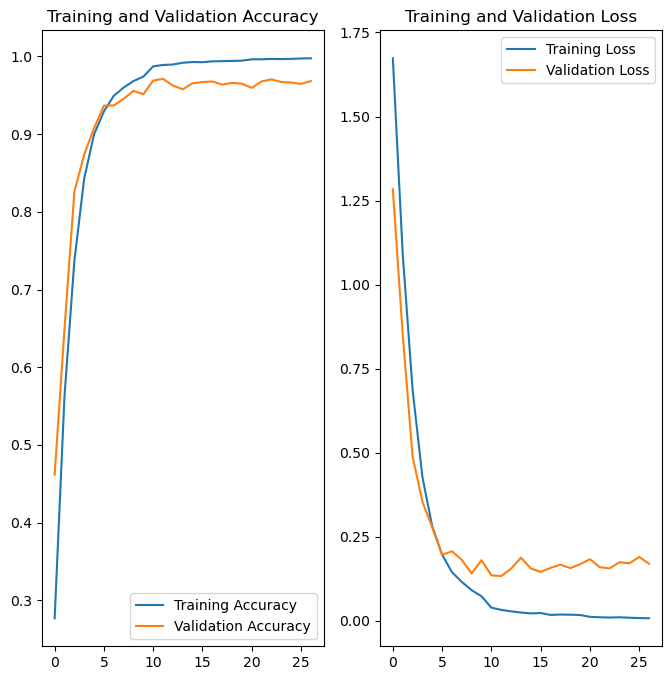

In [18]:
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [19]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

883/883 [==============================] - 15s 17ms/step
Confusion Matrix
[[1163   21    1    2    0   13]
 [   0 1108    1    1   56   12]
 [   0   12 1140    1    1   16]
 [   0    0    0 1184    0    7]
 [   0   15    0    0 1159    0]
 [   1   19    1   19    4 1104]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.97      0.98      1200
           Aedes vexans       0.94      0.94      0.94      1178
     Anopheles sinensis       1.00      0.97      0.99      1170
          Culex pipiens       0.98      0.99      0.99      1191
Culex tritaeniorhynchus       0.95      0.99      0.97      1174
            Non vectors       0.96      0.96      0.96      1148

               accuracy                           0.97      7061
              macro avg       0.97      0.97      0.97      7061
           weighted avg       0.97      0.97      0.97      7061

Model is saved in ./models/Model_SDO_Park_2022-09-

In [20]:
#-----Run 2

In [21]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpa5228nvc/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpa5228nvc/train/Aedes vexans/ = 4737.
No. of files in "/tmp/tmpa5228nvc/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpa5228nvc/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpa5228nvc/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpa5228nvc/val/Aedes vexans/ = 1164.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpa5228nvc/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpa5228nvc/train/Anopheles sinensis/ = 4741.
No. of files in "/tmp/tmpa5228nvc/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpa5228nvc/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpa5228nvc/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpa5228nvc/val/Anopheles sinensis/ = 1182.
Foun

In [22]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28637 files belonging to 6 classes.
Found 7103 files belonging to 6 classes.


In [23]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/28-23:28:04

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3580/3580 [==============================] - 223s 60ms/step - loss: 1.7456 - accuracy: 0.2272 - val_loss: 1.3889 - val_accuracy: 0.3468 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3580/3580 [==============================] - 216s 60ms/step - loss: 1.2436 - accuracy: 0.4882 - val_loss: 0.9503 - val_accuracy: 0.6218 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3580/3580 [==============================] - 217s 61ms/step - loss: 0.7533 - accuracy: 0.7162 - val_loss: 0.5964 - val_accuracy: 0.7739 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3580/3580 [==============================] - 216s 60ms/step - loss: 0.4681 - accuracy: 0.8300 - val_loss: 0.3423 - val_accuracy: 0.872

Epoch 34/40
3580/3580 [==============================] - 209s 58ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.1213 - val_accuracy: 0.9694 - lr: 1.2800e-06

Epoch 35: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 35/40
3580/3580 [==============================] - 212s 59ms/step - loss: 0.0072 - accuracy: 0.9978 - val_loss: 0.1156 - val_accuracy: 0.9703 - lr: 1.2800e-06

Epoch 36: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 36/40
3580/3580 [==============================] - 208s 58ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.1204 - val_accuracy: 0.9699 - lr: 1.2800e-06

Epoch 37: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 37/40
3580/3580 [==============================] - 212s 59ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.1163 - val_accuracy: 0.9720 - lr: 1.2800e-06

Epoch 38: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 38/40


Maximum test accuracy is at 97.2 %.


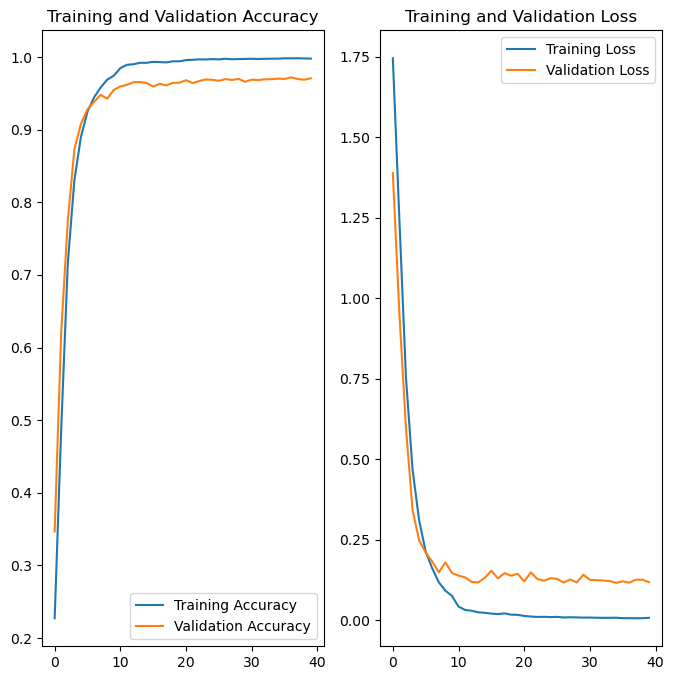

In [24]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [25]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

888/888 [==============================] - 14s 16ms/step
Confusion Matrix
[[1154    7    6    5   10    8]
 [   0 1085    3    0   56   20]
 [   0    1 1179    0    0    2]
 [   0    1    0 1191    0    1]
 [   0   23    0    0 1158    0]
 [   5   23    8   25    4 1128]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.97      0.98      1190
           Aedes vexans       0.95      0.93      0.94      1164
     Anopheles sinensis       0.99      1.00      0.99      1182
          Culex pipiens       0.98      1.00      0.99      1193
Culex tritaeniorhynchus       0.94      0.98      0.96      1181
            Non vectors       0.97      0.95      0.96      1193

               accuracy                           0.97      7103
              macro avg       0.97      0.97      0.97      7103
           weighted avg       0.97      0.97      0.97      7103

Model is saved in ./models/Model_SDO_Park_2022-09-

In [26]:
#-----Run 3

In [27]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpqw30kopc/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpqw30kopc/train/Aedes vexans/ = 4728.
No. of files in "/tmp/tmpqw30kopc/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpqw30kopc/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpqw30kopc/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpqw30kopc/val/Aedes vexans/ = 1173.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpqw30kopc/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpqw30kopc/train/Anopheles sinensis/ = 4739.
No. of files in "/tmp/tmpqw30kopc/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpqw30kopc/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpqw30kopc/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpqw30kopc/val/Anopheles sinensis/ = 1184.
Foun

In [28]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28627 files belonging to 6 classes.
Found 7113 files belonging to 6 classes.


In [29]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/29-01:49:30

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3579/3579 [==============================] - 217s 59ms/step - loss: 1.7436 - accuracy: 0.2253 - val_loss: 1.4167 - val_accuracy: 0.3713 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3579/3579 [==============================] - 214s 60ms/step - loss: 1.2777 - accuracy: 0.4731 - val_loss: 1.0936 - val_accuracy: 0.5373 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3579/3579 [==============================] - 207s 58ms/step - loss: 0.8493 - accuracy: 0.6713 - val_loss: 0.6212 - val_accuracy: 0.7732 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3579/3579 [==============================] - 212s 59ms/step - loss: 0.5679 - accuracy: 0.7895 - val_loss: 0.5848 - val_accuracy: 0.795

Epoch 34/40
3579/3579 [==============================] - 207s 58ms/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 0.1174 - val_accuracy: 0.9699 - lr: 1.2800e-06

Epoch 35: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 35/40
3579/3579 [==============================] - 205s 57ms/step - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.1126 - val_accuracy: 0.9708 - lr: 1.2800e-06

Epoch 36: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 36/40
3579/3579 [==============================] - 208s 58ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.1155 - val_accuracy: 0.9710 - lr: 1.2800e-06

Epoch 37: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 37/40
3579/3579 [==============================] - 206s 58ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.1147 - val_accuracy: 0.9717 - lr: 1.2800e-06

Epoch 38: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 38/40


Maximum test accuracy is at 97.3 %.


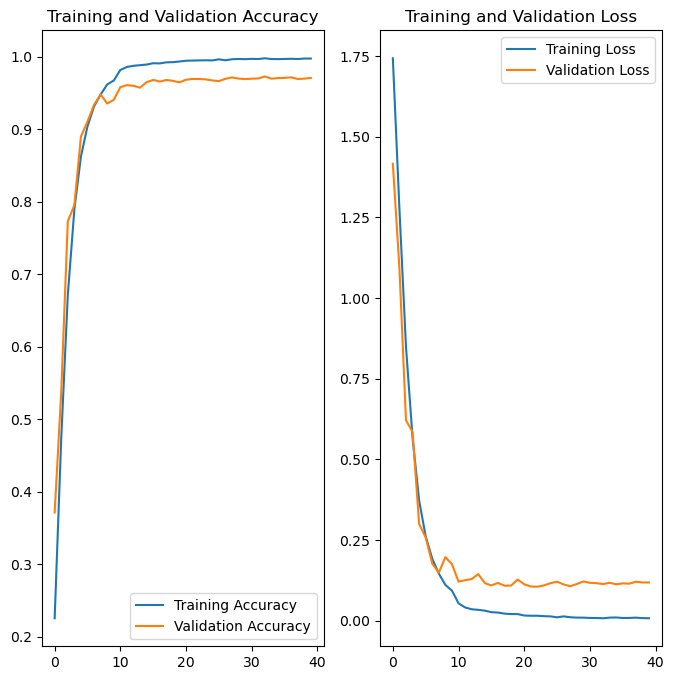

In [30]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [31]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

890/890 [==============================] - 14s 15ms/step
Confusion Matrix
[[1173    6    0    0    1    7]
 [   1 1125    4    0   31   12]
 [   1    4 1171    0    0    8]
 [   1    0    0 1189    0    2]
 [   4   41    0    0 1137    1]
 [   3   41   11   25    3 1111]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99      1187
           Aedes vexans       0.92      0.96      0.94      1173
     Anopheles sinensis       0.99      0.99      0.99      1184
          Culex pipiens       0.98      1.00      0.99      1192
Culex tritaeniorhynchus       0.97      0.96      0.97      1183
            Non vectors       0.97      0.93      0.95      1194

               accuracy                           0.97      7113
              macro avg       0.97      0.97      0.97      7113
           weighted avg       0.97      0.97      0.97      7113

Model is saved in ./models/Model_SDO_Park_2022-09-

In [32]:
#-----Run 4

In [33]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp__0i4p89/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp__0i4p89/train/Aedes vexans/ = 4743.
No. of files in "/tmp/tmp__0i4p89/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp__0i4p89/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp__0i4p89/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp__0i4p89/val/Aedes vexans/ = 1158.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp__0i4p89/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp__0i4p89/train/Anopheles sinensis/ = 4739.
No. of files in "/tmp/tmp__0i4p89/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp__0i4p89/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp__0i4p89/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp__0i4p89/val/Anopheles sinensis/ = 1184.
Foun

In [34]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28653 files belonging to 6 classes.
Found 7087 files belonging to 6 classes.


In [35]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/29-04:08:23

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3582/3582 [==============================] - 214s 58ms/step - loss: 1.7587 - accuracy: 0.2110 - val_loss: 1.4057 - val_accuracy: 0.3902 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3582/3582 [==============================] - 214s 60ms/step - loss: 1.3606 - accuracy: 0.4277 - val_loss: 1.0929 - val_accuracy: 0.6063 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3582/3582 [==============================] - 210s 59ms/step - loss: 0.9476 - accuracy: 0.6321 - val_loss: 0.7529 - val_accuracy: 0.7398 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3582/3582 [==============================] - 215s 60ms/step - loss: 0.6086 - accuracy: 0.7748 - val_loss: 0.4610 - val_accuracy: 0.830

Epoch 34/40
3582/3582 [==============================] - 207s 58ms/step - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.1429 - val_accuracy: 0.9629 - lr: 1.2800e-06

Epoch 35: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 35/40
3582/3582 [==============================] - 200s 56ms/step - loss: 0.0065 - accuracy: 0.9979 - val_loss: 0.1362 - val_accuracy: 0.9643 - lr: 1.2800e-06

Epoch 36: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 36/40
3582/3582 [==============================] - 204s 57ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.1417 - val_accuracy: 0.9633 - lr: 1.2800e-06

Epoch 37: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 37/40
3582/3582 [==============================] - 205s 57ms/step - loss: 0.0075 - accuracy: 0.9974 - val_loss: 0.1434 - val_accuracy: 0.9608 - lr: 1.2800e-06

Epoch 38: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 38/40


Maximum test accuracy is at 96.49 %.


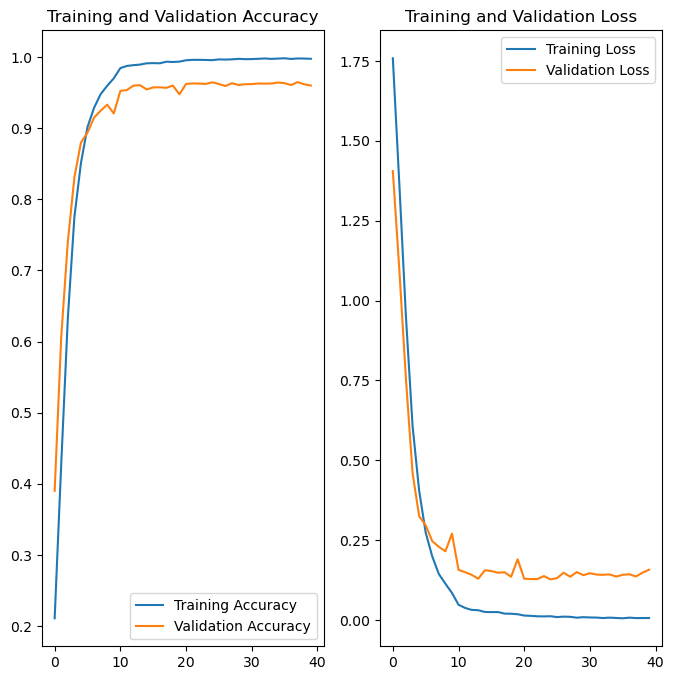

In [36]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [37]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

886/886 [==============================] - 14s 15ms/step
Confusion Matrix
[[1171    0    8    1    2    9]
 [   0 1097    3    7   41   10]
 [   0    1 1176    0    0    7]
 [   0    6    5 1183    0    0]
 [   0   49    2    0 1124    0]
 [   8   26   11   83    4 1053]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.98      0.99      1191
           Aedes vexans       0.93      0.95      0.94      1158
     Anopheles sinensis       0.98      0.99      0.98      1184
          Culex pipiens       0.93      0.99      0.96      1194
Culex tritaeniorhynchus       0.96      0.96      0.96      1175
            Non vectors       0.98      0.89      0.93      1185

               accuracy                           0.96      7087
              macro avg       0.96      0.96      0.96      7087
           weighted avg       0.96      0.96      0.96      7087

Model is saved in ./models/Model_SDO_Park_2022-09-

In [38]:
#-----Run 5

In [39]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmphlf5w6f3/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmphlf5w6f3/train/Aedes vexans/ = 4726.
No. of files in "/tmp/tmphlf5w6f3/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmphlf5w6f3/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmphlf5w6f3/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmphlf5w6f3/val/Aedes vexans/ = 1175.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmphlf5w6f3/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmphlf5w6f3/train/Anopheles sinensis/ = 4759.
No. of files in "/tmp/tmphlf5w6f3/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmphlf5w6f3/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmphlf5w6f3/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmphlf5w6f3/val/Anopheles sinensis/ = 1164.
Foun

In [40]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28642 files belonging to 6 classes.
Found 7098 files belonging to 6 classes.


In [41]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/29-06:27:21

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3581/3581 [==============================] - 214s 58ms/step - loss: 1.6868 - accuracy: 0.2672 - val_loss: 1.4012 - val_accuracy: 0.4067 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3581/3581 [==============================] - 207s 58ms/step - loss: 1.1932 - accuracy: 0.5220 - val_loss: 0.9662 - val_accuracy: 0.6183 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3581/3581 [==============================] - 206s 58ms/step - loss: 0.7502 - accuracy: 0.7196 - val_loss: 0.5943 - val_accuracy: 0.7847 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3581/3581 [==============================] - 204s 57ms/step - loss: 0.4996 - accuracy: 0.8160 - val_loss: 0.4421 - val_accuracy: 0.838

Epoch 34/40
3581/3581 [==============================] - 203s 57ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.1036 - val_accuracy: 0.9752 - lr: 1.2800e-06

Epoch 35: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 35/40
3581/3581 [==============================] - 205s 57ms/step - loss: 0.0073 - accuracy: 0.9973 - val_loss: 0.1040 - val_accuracy: 0.9765 - lr: 1.2800e-06

Epoch 36: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 36/40
3581/3581 [==============================] - 205s 57ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.1069 - val_accuracy: 0.9758 - lr: 1.2800e-06

Epoch 37: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 37/40
3581/3581 [==============================] - 203s 57ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.1046 - val_accuracy: 0.9769 - lr: 1.2800e-06

Epoch 38: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 38/40


Maximum test accuracy is at 97.7 %.


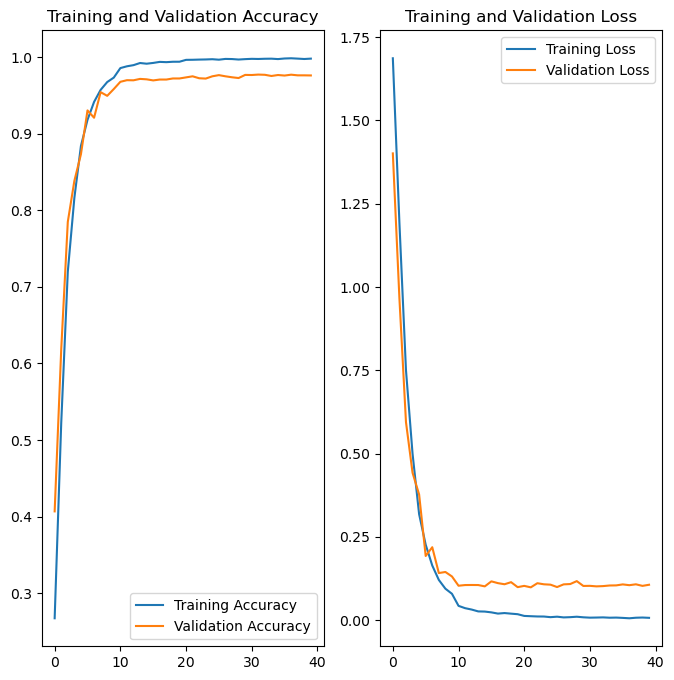

In [42]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [43]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

888/888 [==============================] - 14s 15ms/step
Confusion Matrix
[[1162   15    0    2    4    6]
 [   1 1119    5    1   31   18]
 [   0    4 1158    0    0    2]
 [   1    0    2 1182    0    2]
 [   1   21    2    0 1158    0]
 [   4   19    3   24    3 1148]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.98      0.99      1189
           Aedes vexans       0.95      0.95      0.95      1175
     Anopheles sinensis       0.99      0.99      0.99      1164
          Culex pipiens       0.98      1.00      0.99      1187
Culex tritaeniorhynchus       0.97      0.98      0.97      1182
            Non vectors       0.98      0.96      0.97      1201

               accuracy                           0.98      7098
              macro avg       0.98      0.98      0.98      7098
           weighted avg       0.98      0.98      0.98      7098

Model is saved in ./models/Model_SDO_Park_2022-09-

In [44]:
#-----Run 6

In [45]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp90w2itic/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp90w2itic/train/Aedes vexans/ = 4731.
No. of files in "/tmp/tmp90w2itic/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp90w2itic/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp90w2itic/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp90w2itic/val/Aedes vexans/ = 1170.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp90w2itic/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp90w2itic/train/Anopheles sinensis/ = 4760.
No. of files in "/tmp/tmp90w2itic/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp90w2itic/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp90w2itic/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp90w2itic/val/Anopheles sinensis/ = 1163.
Foun

In [46]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28692 files belonging to 6 classes.
Found 7048 files belonging to 6 classes.


In [47]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/29-08:45:25

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3587/3587 [==============================] - 215s 58ms/step - loss: 1.6444 - accuracy: 0.2827 - val_loss: 1.2800 - val_accuracy: 0.4925 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3587/3587 [==============================] - 205s 57ms/step - loss: 1.1018 - accuracy: 0.5643 - val_loss: 0.9030 - val_accuracy: 0.6433 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3587/3587 [==============================] - 212s 59ms/step - loss: 0.6611 - accuracy: 0.7514 - val_loss: 0.4071 - val_accuracy: 0.8537 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3587/3587 [==============================] - 203s 57ms/step - loss: 0.4139 - accuracy: 0.8472 - val_loss: 0.3173 - val_accuracy: 0.884

Epoch 34/40
3587/3587 [==============================] - 207s 58ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.1264 - val_accuracy: 0.9695 - lr: 1.2800e-06

Epoch 35: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 35/40
3587/3587 [==============================] - 207s 58ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.1308 - val_accuracy: 0.9706 - lr: 1.2800e-06

Epoch 36: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 36/40
3587/3587 [==============================] - 206s 58ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.1266 - val_accuracy: 0.9706 - lr: 1.2800e-06

Epoch 37: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 37/40
3587/3587 [==============================] - 205s 57ms/step - loss: 0.0051 - accuracy: 0.9984 - val_loss: 0.1304 - val_accuracy: 0.9694 - lr: 1.2800e-06

Epoch 38: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 38/40


Maximum test accuracy is at 97.26 %.


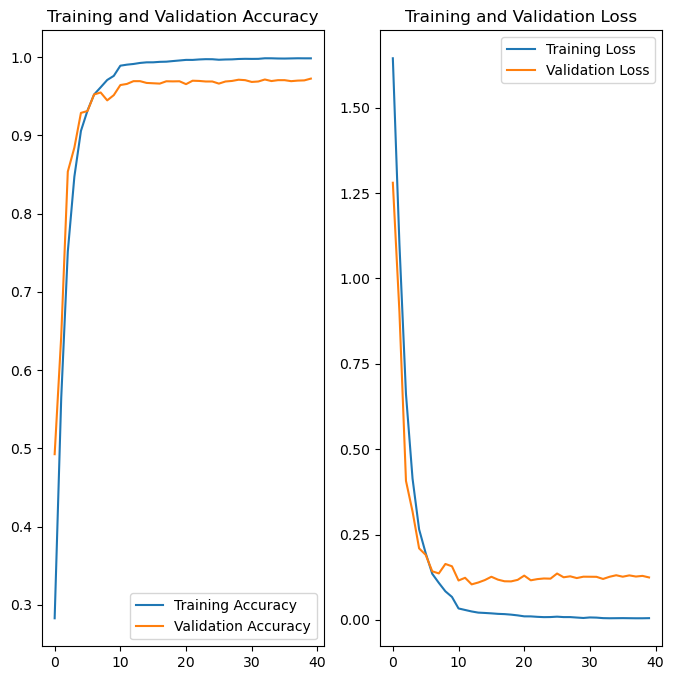

In [48]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [49]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

881/881 [==============================] - 14s 15ms/step
Confusion Matrix
[[1169   11    0    2    1    6]
 [   2 1131    0    0   30    7]
 [   0    7 1137    0    0   19]
 [   0    2    1 1183    0    3]
 [   0   43    0    0 1128    0]
 [   3   14   13   28    1 1107]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.98      0.99      1189
           Aedes vexans       0.94      0.97      0.95      1170
     Anopheles sinensis       0.99      0.98      0.98      1163
          Culex pipiens       0.98      0.99      0.99      1189
Culex tritaeniorhynchus       0.97      0.96      0.97      1171
            Non vectors       0.97      0.95      0.96      1166

               accuracy                           0.97      7048
              macro avg       0.97      0.97      0.97      7048
           weighted avg       0.97      0.97      0.97      7048

Model is saved in ./models/Model_SDO_Park_2022-09-

In [50]:
#-----Run 7

In [51]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpt3qsnjif/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpt3qsnjif/train/Aedes vexans/ = 4740.
No. of files in "/tmp/tmpt3qsnjif/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpt3qsnjif/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpt3qsnjif/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpt3qsnjif/val/Aedes vexans/ = 1161.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpt3qsnjif/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpt3qsnjif/train/Anopheles sinensis/ = 4754.
No. of files in "/tmp/tmpt3qsnjif/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpt3qsnjif/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpt3qsnjif/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpt3qsnjif/val/Anopheles sinensis/ = 1169.
Foun

In [52]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28669 files belonging to 6 classes.
Found 7071 files belonging to 6 classes.


In [53]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/29-11:03:27

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3584/3584 [==============================] - 214s 58ms/step - loss: 1.6875 - accuracy: 0.2658 - val_loss: 1.3147 - val_accuracy: 0.4210 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3584/3584 [==============================] - 213s 60ms/step - loss: 1.1594 - accuracy: 0.5291 - val_loss: 0.8009 - val_accuracy: 0.6897 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3584/3584 [==============================] - 207s 58ms/step - loss: 0.7506 - accuracy: 0.7117 - val_loss: 0.5654 - val_accuracy: 0.7914 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3584/3584 [==============================] - 208s 58ms/step - loss: 0.4720 - accuracy: 0.8249 - val_loss: 0.3453 - val_accuracy: 0.870

Epoch 34/40
3584/3584 [==============================] - 205s 57ms/step - loss: 0.0078 - accuracy: 0.9977 - val_loss: 0.0966 - val_accuracy: 0.9740 - lr: 1.2800e-06

Epoch 35: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 35/40
3584/3584 [==============================] - 206s 57ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0958 - val_accuracy: 0.9743 - lr: 1.2800e-06

Epoch 36: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 36/40
3584/3584 [==============================] - 204s 57ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.1002 - val_accuracy: 0.9726 - lr: 1.2800e-06

Epoch 37: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 37/40
3584/3584 [==============================] - 204s 57ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0961 - val_accuracy: 0.9738 - lr: 1.2800e-06

Epoch 38: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 38/40


Maximum test accuracy is at 97.47 %.


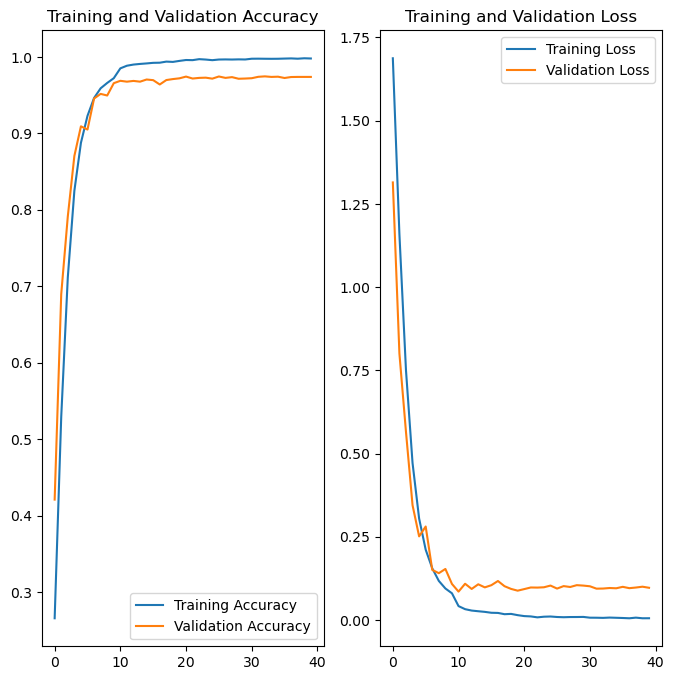

In [54]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [55]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

884/884 [==============================] - 14s 15ms/step
Confusion Matrix
[[1157   15    1    7    0    9]
 [   0 1120    1    0   15   25]
 [   1   12 1152    2    0    2]
 [   1    1    0 1189    0    2]
 [   0   35    1    0 1124    0]
 [   3   30    4   13    4 1145]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.97      0.98      1189
           Aedes vexans       0.92      0.96      0.94      1161
     Anopheles sinensis       0.99      0.99      0.99      1169
          Culex pipiens       0.98      1.00      0.99      1193
Culex tritaeniorhynchus       0.98      0.97      0.98      1160
            Non vectors       0.97      0.95      0.96      1199

               accuracy                           0.97      7071
              macro avg       0.97      0.97      0.97      7071
           weighted avg       0.97      0.97      0.97      7071

Model is saved in ./models/Model_SDO_Park_2022-09-

In [56]:
#-----Run 8

In [57]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp979ty2qy/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp979ty2qy/train/Aedes vexans/ = 4727.
No. of files in "/tmp/tmp979ty2qy/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp979ty2qy/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp979ty2qy/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp979ty2qy/val/Aedes vexans/ = 1174.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp979ty2qy/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp979ty2qy/train/Anopheles sinensis/ = 4749.
No. of files in "/tmp/tmp979ty2qy/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp979ty2qy/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp979ty2qy/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp979ty2qy/val/Anopheles sinensis/ = 1174.
Foun

In [58]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28656 files belonging to 6 classes.
Found 7084 files belonging to 6 classes.


In [59]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/29-13:21:15

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3582/3582 [==============================] - 220s 59ms/step - loss: 1.6796 - accuracy: 0.2765 - val_loss: 1.3578 - val_accuracy: 0.4704 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3582/3582 [==============================] - 204s 57ms/step - loss: 1.0874 - accuracy: 0.5676 - val_loss: 0.7409 - val_accuracy: 0.7096 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3582/3582 [==============================] - 209s 58ms/step - loss: 0.6595 - accuracy: 0.7536 - val_loss: 0.4208 - val_accuracy: 0.8435 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3582/3582 [==============================] - 207s 58ms/step - loss: 0.4044 - accuracy: 0.8540 - val_loss: 0.2811 - val_accuracy: 0.903

Epoch 34/40
3582/3582 [==============================] - 206s 58ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.1490 - val_accuracy: 0.9651 - lr: 1.2800e-06

Epoch 35: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 35/40
3582/3582 [==============================] - 206s 57ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.1439 - val_accuracy: 0.9658 - lr: 1.2800e-06

Epoch 36: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 36/40
3582/3582 [==============================] - 208s 58ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.1456 - val_accuracy: 0.9657 - lr: 1.2800e-06

Epoch 37: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 37/40
3582/3582 [==============================] - 206s 57ms/step - loss: 0.0064 - accuracy: 0.9977 - val_loss: 0.1493 - val_accuracy: 0.9649 - lr: 1.2800e-06

Epoch 38: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 38/40


Maximum test accuracy is at 96.7 %.


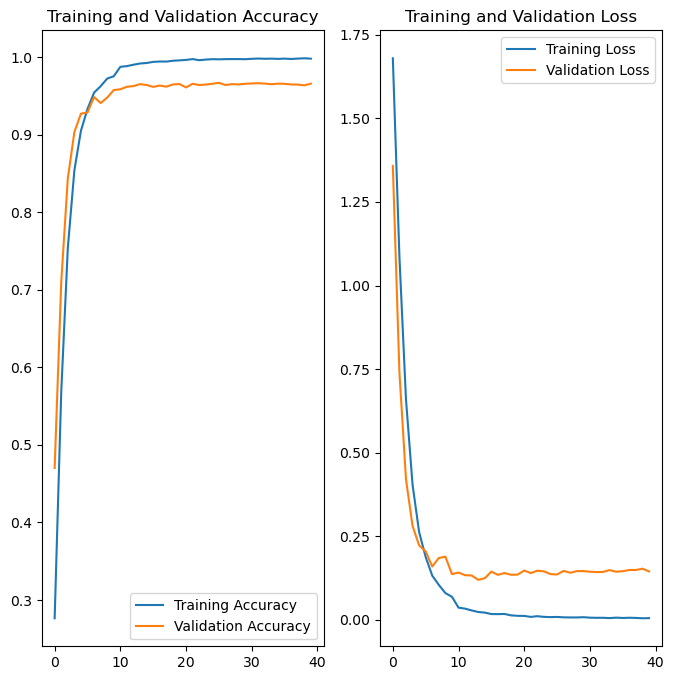

In [60]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [61]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

886/886 [==============================] - 14s 15ms/step
Confusion Matrix
[[1174    8    0    1    0    0]
 [   1 1123    1    3   34   12]
 [   2   21 1109    0    2   40]
 [   0    4    0 1182    2    3]
 [   0   31    0    0 1140    0]
 [  12   20    6   37    2 1114]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99      1183
           Aedes vexans       0.93      0.96      0.94      1174
     Anopheles sinensis       0.99      0.94      0.97      1174
          Culex pipiens       0.97      0.99      0.98      1191
Culex tritaeniorhynchus       0.97      0.97      0.97      1171
            Non vectors       0.95      0.94      0.94      1191

               accuracy                           0.97      7084
              macro avg       0.97      0.97      0.97      7084
           weighted avg       0.97      0.97      0.97      7084

Model is saved in ./models/Model_SDO_Park_2022-09-

In [62]:
#-----Run 9

In [63]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpwmvvk3dj/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpwmvvk3dj/train/Aedes vexans/ = 4723.
No. of files in "/tmp/tmpwmvvk3dj/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpwmvvk3dj/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpwmvvk3dj/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpwmvvk3dj/val/Aedes vexans/ = 1178.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpwmvvk3dj/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpwmvvk3dj/train/Anopheles sinensis/ = 4746.
No. of files in "/tmp/tmpwmvvk3dj/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpwmvvk3dj/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpwmvvk3dj/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpwmvvk3dj/val/Anopheles sinensis/ = 1177.
Foun

In [64]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28636 files belonging to 6 classes.
Found 7104 files belonging to 6 classes.


In [65]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/29-15:39:18

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3580/3580 [==============================] - 218s 59ms/step - loss: 1.7372 - accuracy: 0.2339 - val_loss: 1.3660 - val_accuracy: 0.4120 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3580/3580 [==============================] - 205s 57ms/step - loss: 1.2601 - accuracy: 0.4762 - val_loss: 0.8908 - val_accuracy: 0.6298 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3580/3580 [==============================] - 209s 58ms/step - loss: 0.7999 - accuracy: 0.6920 - val_loss: 0.6488 - val_accuracy: 0.7530 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3580/3580 [==============================] - 208s 58ms/step - loss: 0.5006 - accuracy: 0.8165 - val_loss: 0.3410 - val_accuracy: 0.878

Epoch 34/40
3580/3580 [==============================] - 203s 57ms/step - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.1317 - val_accuracy: 0.9707 - lr: 1.2800e-06

Epoch 35: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 35/40
3580/3580 [==============================] - 205s 57ms/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.1279 - val_accuracy: 0.9713 - lr: 1.2800e-06

Epoch 36: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 36/40
3580/3580 [==============================] - 205s 57ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.1291 - val_accuracy: 0.9703 - lr: 1.2800e-06

Epoch 37: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 37/40
3580/3580 [==============================] - 204s 57ms/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.1302 - val_accuracy: 0.9699 - lr: 1.2800e-06

Epoch 38: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 38/40


Maximum test accuracy is at 97.14 %.


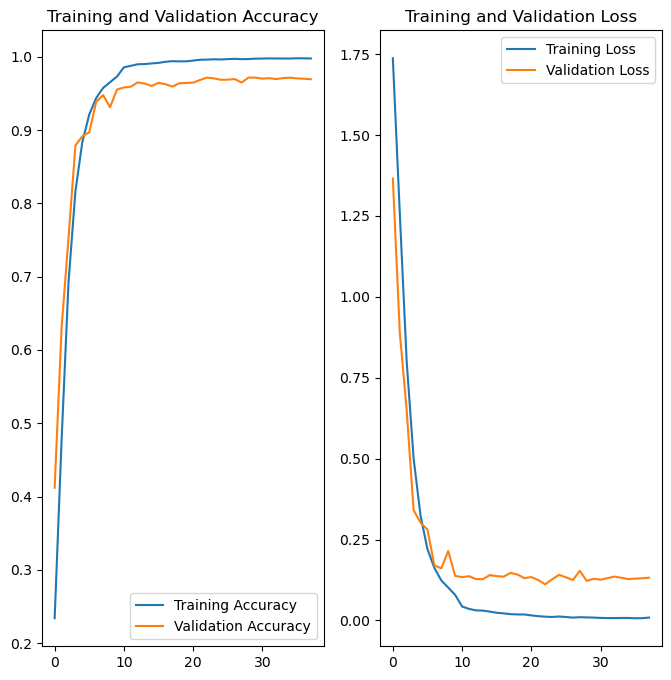

In [66]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [67]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

888/888 [==============================] - 14s 15ms/step
Confusion Matrix
[[1154   27    1    0    0    5]
 [   0 1119    2    1   46   10]
 [   1   14 1157    0    1    4]
 [   0    3    5 1177    0    4]
 [   0   30    0    0 1144    0]
 [   9    8   13   18    1 1150]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.97      0.98      1187
           Aedes vexans       0.93      0.95      0.94      1178
     Anopheles sinensis       0.98      0.98      0.98      1177
          Culex pipiens       0.98      0.99      0.99      1189
Culex tritaeniorhynchus       0.96      0.97      0.97      1174
            Non vectors       0.98      0.96      0.97      1199

               accuracy                           0.97      7104
              macro avg       0.97      0.97      0.97      7104
           weighted avg       0.97      0.97      0.97      7104

Model is saved in ./models/Model_SDO_Park_2022-09-

In [68]:
#-----Run 10

In [69]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))

#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmptm46t6q7/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmptm46t6q7/train/Aedes vexans/ = 4738.
No. of files in "/tmp/tmptm46t6q7/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmptm46t6q7/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmptm46t6q7/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmptm46t6q7/val/Aedes vexans/ = 1163.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmptm46t6q7/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmptm46t6q7/train/Anopheles sinensis/ = 4757.
No. of files in "/tmp/tmptm46t6q7/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmptm46t6q7/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmptm46t6q7/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmptm46t6q7/val/Anopheles sinensis/ = 1166.
Foun

In [70]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28671 files belonging to 6 classes.
Found 7069 files belonging to 6 classes.


In [71]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/29-17:50:25

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3584/3584 [==============================] - 215s 58ms/step - loss: 1.6797 - accuracy: 0.2756 - val_loss: 1.3691 - val_accuracy: 0.3967 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3584/3584 [==============================] - 207s 58ms/step - loss: 1.1988 - accuracy: 0.5073 - val_loss: 0.9879 - val_accuracy: 0.6018 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3584/3584 [==============================] - 209s 58ms/step - loss: 0.7361 - accuracy: 0.7191 - val_loss: 0.5224 - val_accuracy: 0.8143 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3584/3584 [==============================] - 207s 58ms/step - loss: 0.4754 - accuracy: 0.8229 - val_loss: 0.3271 - val_accuracy: 0.883

Epoch 34/40
3584/3584 [==============================] - 205s 57ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.1085 - val_accuracy: 0.9757 - lr: 1.2800e-06

Epoch 35: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 35/40
3584/3584 [==============================] - 205s 57ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.1071 - val_accuracy: 0.9755 - lr: 1.2800e-06

Epoch 36: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 36/40
3584/3584 [==============================] - 204s 57ms/step - loss: 0.0065 - accuracy: 0.9979 - val_loss: 0.1134 - val_accuracy: 0.9738 - lr: 1.2800e-06

Epoch 37: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 37/40
3584/3584 [==============================] - 205s 57ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.1138 - val_accuracy: 0.9752 - lr: 1.2800e-06

Epoch 38: LearningRateScheduler setting learning rate to 1.2799999922208372e-06.
Epoch 38/40


Maximum test accuracy is at 97.68 %.


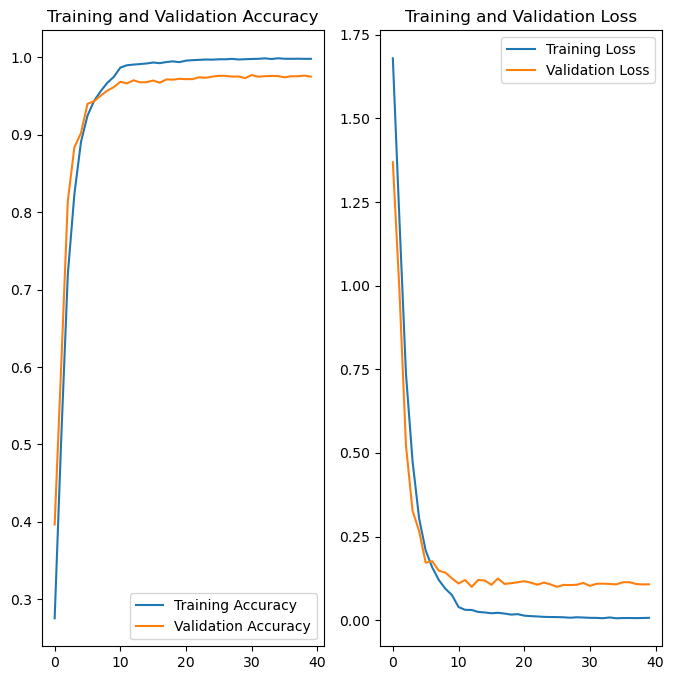

In [72]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [73]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

884/884 [==============================] - 14s 15ms/step
Confusion Matrix
[[1177    9    1    2    0    5]
 [   0 1107    5    1   42    8]
 [   3    0 1160    0    1    2]
 [   0    5    0 1181    0    0]
 [   2   35    1    0 1121    0]
 [   6   21    4   22    3 1145]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99      1194
           Aedes vexans       0.94      0.95      0.95      1163
     Anopheles sinensis       0.99      0.99      0.99      1166
          Culex pipiens       0.98      1.00      0.99      1186
Culex tritaeniorhynchus       0.96      0.97      0.96      1159
            Non vectors       0.99      0.95      0.97      1201

               accuracy                           0.97      7069
              macro avg       0.97      0.97      0.97      7069
           weighted avg       0.97      0.97      0.97      7069

Model is saved in ./models/Model_SDO_Park_2022-09-